MPII 데이터셋 다운로드하기

## 데이터 전처리하기

In [1]:
import csv
import io
import json
import os

os.environ["CUDA_VISIBLE_DEVICES"] = '-1' #CPU 사용
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

workdir = os.path.join(os.getenv('HOME'),'aiffel/mpii')
os.chdir(workdir)

from loguru import logger
from PIL import Image
import ray
import tensorflow as tf

num_train_shards = 64
num_val_shards = 8
ray.init()
tf.get_logger().setLevel('ERROR')

2021-11-12 00:02:35,852	WARNING utils.py:480 -- Detecting docker specified CPUs. In previous versions of Ray, CPU detection in containers was incorrect. Please ensure that Ray has enough CPUs allocated. As a temporary workaround to revert to the prior behavior, set `RAY_USE_MULTIPROCESSING_CPU_COUNT=1` as an env var before starting Ray. Set the env var: `RAY_DISABLE_DOCKER_CPU_WARNING=1` to mute this warning.
2021-11-12 00:02:36,330	INFO services.py:1173 -- View the Ray dashboard at http://127.0.0.1:8265
2021-11-12 00:02:36,334	WARNING services.py:1640 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This may slow down performance! You may be able to free up space by deleting files in /dev/shm or terminating any running plasma_store_server processes. If you are inside a Docker container, you may need to pass an argument with the flag '--shm-size' to 'docker run'.


### json parsing

In [2]:
import json, os

json_file_path = os.getenv('HOME')+'/aiffel/mpii/mpii_human_pose_v1_u12_2/train.json'

with open(json_file_path) as train_json:
    train_annos = json.load(train_json)
    json_formatted_str = json.dumps(train_annos[0], indent=2) # json beautify
    print(json_formatted_str)

{
  "joints_vis": [
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1
  ],
  "joints": [
    [
      620.0,
      394.0
    ],
    [
      616.0,
      269.0
    ],
    [
      573.0,
      185.0
    ],
    [
      647.0,
      188.0
    ],
    [
      661.0,
      221.0
    ],
    [
      656.0,
      231.0
    ],
    [
      610.0,
      187.0
    ],
    [
      647.0,
      176.0
    ],
    [
      637.0201,
      189.8183
    ],
    [
      695.9799,
      108.1817
    ],
    [
      606.0,
      217.0
    ],
    [
      553.0,
      161.0
    ],
    [
      601.0,
      167.0
    ],
    [
      692.0,
      185.0
    ],
    [
      693.0,
      240.0
    ],
    [
      688.0,
      313.0
    ]
  ],
  "image": "015601864.jpg",
  "scale": 3.021046,
  "center": [
    594.0,
    257.0
  ]
}


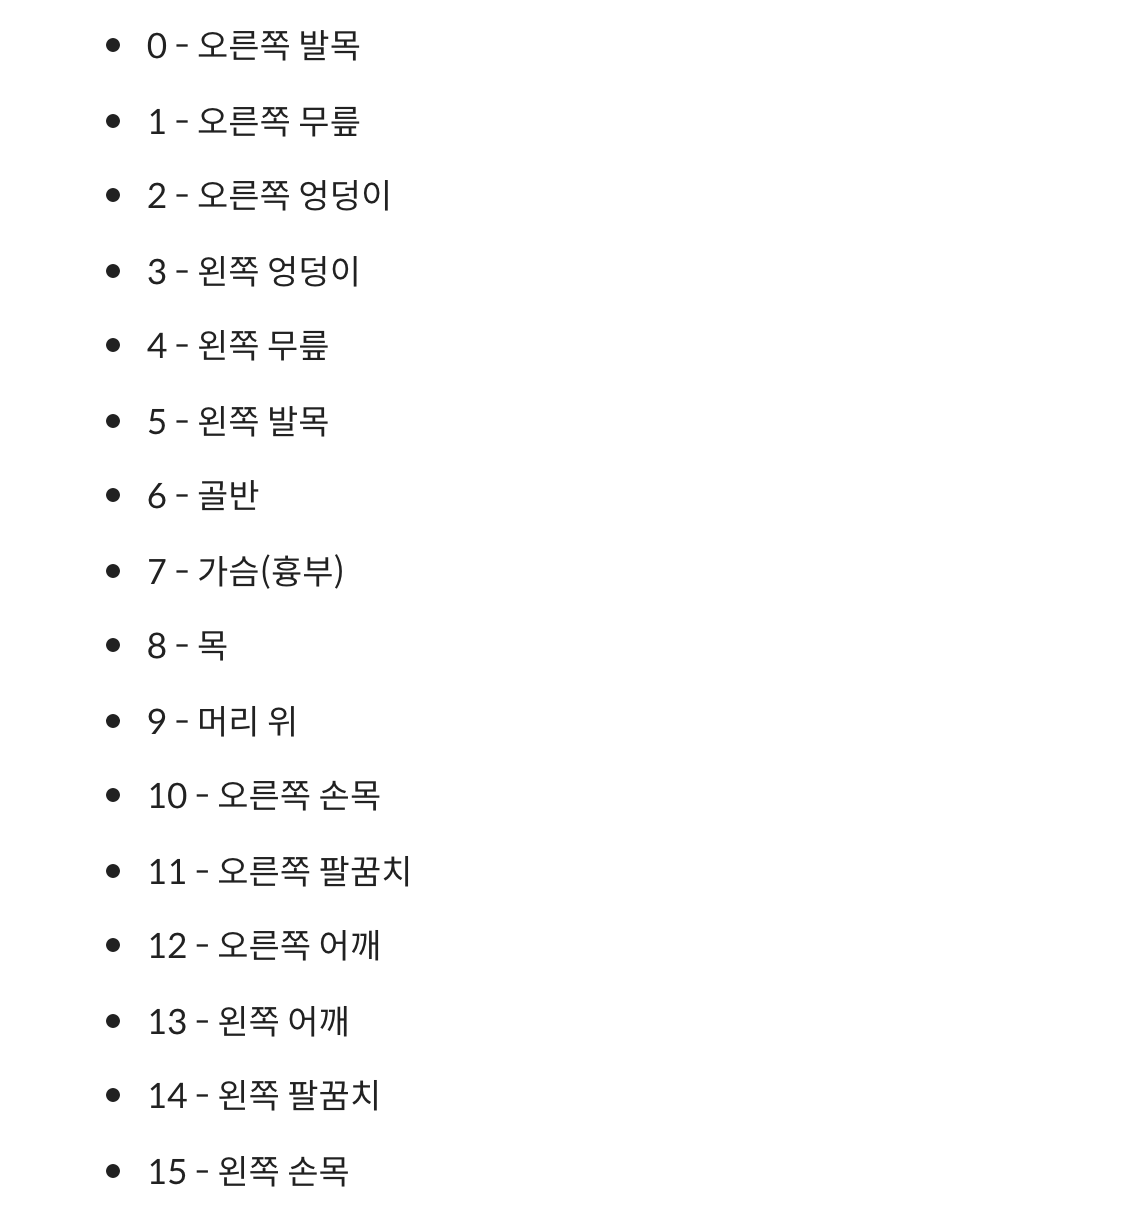

높이 = scale x 200px  
center = 사람의 중심점  


In [3]:
def parse_one_annotation(annot, image_dir):
    fileName = annot['image']
    joint = annot['joints']
    jointsVisibility = annot['joints_vis']
    annotation = {
        'filename':fileName,
        'filepath':os.path.jotin(image_dir, fileName),
        'jointsVisibility': joints_visibility,
        'joints': joints,
        'center': annot['center'],
        'scale': annot['scale']
    }
    
    return annotation

### tfrecord 파일 만들기
protocol buffer를 사용하여 데이터를 직렬화한다.

In [4]:
import ray

def build_tf_records(annotations, total_shards, split):
    chunks = chunkify(annotations, tatal_shards)
    features = [
        # train_0001_of_0064.tfrecords
        build_single_tfrecord.remote(
            chunk, './tfrecords_mpii/{}_{}_of_{}.tfrecords'.format(
                split,
                str(i + 1).zfill(4),
                str(total_shards).zfill(4),
            )) for i, chunk in enumerate(chunks)
    ]
    ray.get(futures)

- Chunkify = annnotation 을  total_shards 개수로 나누는 것  
- build_single_tfrecord = tfrecord로 저장  
- 각 chunk끼리 dependency가 없기 때문에 병렬처리가 가능, ray를 사용

** annotation을 shard로 나누는 이유?  
-> 병목 현상을 막기위해 병렬적으로 처리하기 위함이다.


In [5]:
# annotation을 적절한 개수로 나누는 함수 정의
def chunkify(l,n):
        size = len(l)// n
        start = 0
        result =[]
        for i in range(n - 1):
            result.append(1[start:start+size])
            start += size
        result.append(1[start:])
        return results
            

- l : annotation, n은 shard 개수
- shard 개수 단위로 annotation list를 나누어서 새로운 list를 만든다.  

In [6]:
# tfrecord 1개를 저장하는 함수 정의
 
@ray.remote
def build_single_tfrecod(chunk, path):
    print('start to build tf records for ' + path)
    
    with tf.io.TFRecordWrite(path) as writer:
        for anno_list in chunk:
            tf_example = generate_tfexample(anno_list)
            writer.write(tf_example.SerializeToString())
        
    print('finished building tf records for '+ path)

- TFRecordWriter 를 이용해서 anno_list 를 shard 개수 단위로 작성합니다.  
- generate_tfexample 함수를 사용합니다. → 아래에서 자세히 설명하겠습니다.  
-  중요 write 할 때 string 으로 serialize 해야 합니다.

In [7]:
def generate_tfexample(anno):
    filename = anno['filename']
    filepath = anno['filepath']
    with open(filepath, 'rb') as image_file:
        content = image_file.read()

    image = Image.open(filepath)
    if image.format != 'JPEG' or image.mode != 'RGB':
        image_rgb = image.convert('RGB')
        with io.BytesIO() as output:
            image_rgb.save(output, format="JPEG", quality=95)
            content = output.getvalue()

    width, height = image.size
    depth = 3

    c_x = int(anno['center'][0])
    c_y = int(anno['center'][1])
    scale = anno['scale']

    x = [
        int(joint[0]) if joint[0] >= 0 else int(joint[0]) 
        for joint in anno['joints']
    ]
    y = [
        int(joint[1]) if joint[1] >= 0 else int(joint[0]) 
        for joint in anno['joints']
    ]
    # 0 - invisible, 1 - occluded, 2 - visible
    v = [0 if joint_v == 0 else 2 for joint_v in anno['joints_visibility']]

    feature = {
        'image/height':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        'image/width':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        'image/depth':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[depth])),
        'image/object/parts/x':
        tf.train.Feature(int64_list=tf.train.Int64List(value=x)),
        'image/object/parts/y':
        tf.train.Feature(int64_list=tf.train.Int64List(value=y)),
        'image/object/center/x': 
        tf.train.Feature(int64_list=tf.train.Int64List(value=[c_x])),
        'image/object/center/y': 
        tf.train.Feature(int64_list=tf.train.Int64List(value=[c_y])),
        'image/object/scale':
        tf.train.Feature(float_list=tf.train.FloatList(value=[scale])),
        'image/object/parts/v':
        tf.train.Feature(int64_list=tf.train.Int64List(value=v)),
        'image/encoded':
        _bytes_feature(content),
        'image/filename':
        _bytes_feature(filename.encode())
    }

    return tf.train.Example(features=tf.train.Features(feature=feature))

In [8]:
def _bytes_feature(value):
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy(
        )  # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

## Ray
Ray는 파이썬을 위한 간단한 분산 애플리케이션 api이다.(multiprocessing을 생각하면 된다.)  
[Ray]https://docs.ray.io/en/latest/


In [9]:
# import csv
# import io
# import json
# import os

# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# from loguru import logger
# from PIL import Image
# import ray
# import tensorflow as tf

# num_train_shards = 64
# num_val_shards = 8
# ray.init()
# tf.get_logger().setLevel('ERROR')


# def chunkify(l, n):
#     size = len(l) // n
#     start = 0
#     results = []
#     for i in range(n - 1):
#         results.append(l[start:start + size])
#         start += size
#     results.append(l[start:])
#     return results


# def _bytes_feature(value):
#     if isinstance(value, type(tf.constant(0))):
#         value = value.numpy(
#         )  # BytesList won't unpack a string from an EagerTensor.
#     return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


# def generate_tfexample(anno):
#     filename = anno['filename']
#     filepath = anno['filepath']
#     with open(filepath, 'rb') as image_file:
#         content = image_file.read()

#     image = Image.open(filepath)
#     if image.format != 'JPEG' or image.mode != 'RGB':
#         image_rgb = image.convert('RGB')
#         with io.BytesIO() as output:
#             image_rgb.save(output, format="JPEG", quality=95)
#             content = output.getvalue()

#     width, height = image.size
#     depth = 3

#     c_x = int(anno['center'][0])
#     c_y = int(anno['center'][1])
#     scale = anno['scale']

#     # x = [
#     #     joint[0] / width if joint[0] >= 0 else joint[0]
#     #     for joint in anno['joints']
#     # ]
#     # y = [
#     #     joint[1] / height if joint[1] >= 0 else joint[0]
#     #     for joint in anno['joints']
#     # ]
#     x = [
#         int(joint[0]) if joint[0] >= 0 else int(joint[0]) 
#         for joint in anno['joints']
#     ]
#     y = [
#         int(joint[1]) if joint[1] >= 0 else int(joint[0]) 
#         for joint in anno['joints']
#     ]
#     # 0 - invisible, 1 - occluded, 2 - visible
#     v = [0 if joint_v == 0 else 2 for joint_v in anno['joints_visibility']]

#     feature = {
#         'image/height':
#         tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
#         'image/width':
#         tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
#         'image/depth':
#         tf.train.Feature(int64_list=tf.train.Int64List(value=[depth])),
#         'image/object/parts/x':
#         tf.train.Feature(int64_list=tf.train.Int64List(value=x)),
#         'image/object/parts/y':
#         tf.train.Feature(int64_list=tf.train.Int64List(value=y)),
#         'image/object/center/x': 
#         tf.train.Feature(int64_list=tf.train.Int64List(value=[c_x])),
#         'image/object/center/y': 
#         tf.train.Feature(int64_list=tf.train.Int64List(value=[c_y])),
#         'image/object/scale':
#         tf.train.Feature(float_list=tf.train.FloatList(value=[scale])),
#         # 'image/object/parts/x':
#         # tf.train.Feature(float_list=tf.train.FloatList(value=x)),
#         # 'image/object/parts/y':
#         # tf.train.Feature(float_list=tf.train.FloatList(value=y)),
#         'image/object/parts/v':
#         tf.train.Feature(int64_list=tf.train.Int64List(value=v)),
#         'image/encoded':
#         _bytes_feature(content),
#         'image/filename':
#         _bytes_feature(filename.encode())
#     }

#     return tf.train.Example(features=tf.train.Features(feature=feature))


# @ray.remote
# def build_single_tfrecord(chunk, path):
#     print('start to build tf records for ' + path)

#     with tf.io.TFRecordWriter(path) as writer:
#         for anno_list in chunk:
#             tf_example = generate_tfexample(anno_list)
#             writer.write(tf_example.SerializeToString())

#     print('finished building tf records for ' + path)


# def build_tf_records(annotations, total_shards, split):
#     chunks = chunkify(annotations, total_shards)
#     futures = [
#         # train_0001_of_0064.tfrecords
#         build_single_tfrecord.remote(
#             chunk, './tfrecords_mpii/{}_{}_of_{}.tfrecords'.format(
#                 split,
#                 str(i + 1).zfill(4),
#                 str(total_shards).zfill(4),
#             )) for i, chunk in enumerate(chunks)
#     ]
#     ray.get(futures)


# def parse_one_annotation(anno, image_dir):
#     filename = anno['image']
#     joints = anno['joints']
#     joints_visibility = anno['joints_vis']
#     annotation = {
#         'filename': filename,
#         'filepath': os.path.join(image_dir, filename),
#         'joints_visibility': joints_visibility,
#         'joints': joints,
#         'center': anno['center'],
#         'scale' : anno['scale']
#     }
#     return annotation


# def main():
#     print('Start to parse annotations.')
#     if not os.path.exists('./tfrecords_mpii'):
#         os.makedirs('./tfrecords_mpii')

#     with open('./mpii_human_pose_v1_u12_2/train.json') as train_json:
#         train_annos = json.load(train_json)
#         train_annotations = [
#             parse_one_annotation(anno, './images/')
#             for anno in train_annos
#         ]
#         print('First train annotation: ', train_annotations[0])
#         del (train_annos)

#     with open('./mpii_human_pose_v1_u12_2/validation.json') as val_json:
#         val_annos = json.load(val_json)
#         val_annotations = [
#             parse_one_annotation(anno, './images/') for anno in val_annos
#         ]
#         print('First val annotation: ', val_annotations[0])
#         del (val_annos)

#     print('Start to build TF Records.')
#     build_tf_records(train_annotations, num_train_shards, 'train')
#     build_tf_records(val_annotations, num_val_shards, 'val')

#     print('Successfully wrote {} annotations to TF Records.'.format(
#         len(train_annotations) + len(val_annotations)))


# if __name__ == '__main__':
#     main()

#     # requirement -pip install -U ray



## data label 로 만들기

In [10]:
import tensorflow as tf

class Preprocessor(object):
    def __init__(self,
                 image_shape=(256, 256, 3),
                 heatmap_shape=(64, 64, 16),
                 is_train=False):
        self.is_train = is_train
        self.image_shape = image_shape
        self.heatmap_shape = heatmap_shape

    def __call__(self, example):
        features = self.parse_tfexample(example)
        image = tf.io.decode_jpeg(features['image/encoded'])

        if self.is_train:
            random_margin = tf.random.uniform([1], 0.1, 0.3)[0]
            image, keypoint_x, keypoint_y = self.crop_roi(image, features, margin=random_margin)
            image = tf.image.resize(image, self.image_shape[0:2])
        else:
            image, keypoint_x, keypoint_y = self.crop_roi(image, features)
            image = tf.image.resize(image, self.image_shape[0:2])

        image = tf.cast(image, tf.float32) / 127.5 - 1
        heatmaps = self.make_heatmaps(features, keypoint_x, keypoint_y)

        # print (image.shape, heatmaps.shape, type(heatmaps))

        return image, heatmaps
				

In [11]:
    def parse_tfexample(self, example_proto):
        image_feature_description = {
            'image/height': tf.io.FixedLenFeature([], tf.int64),
            'image/width': tf.io.FixedLenFeature([], tf.int64),
            'imaage/depth': tf.io.FixedLenFeature([], tf.int64),
            'image/object/parts/x': tf.io.VarLenFeature(tf.int64),
            'image/object/parts/y': tf.io.VarLenFeature(tf.int64),
            'image/object/parts/v': tf.io.VarLenFeature(tf.int64),
            'image/object/center/x': tf.io.FixedLenFeature([], tf.int64),
            'image/object/center/y': tf.io.FixedLenFeature([], tf.int64),
            'image/object/scale': tf.io.FixedLenFeature([], tf.float32),
            'image/encoded': tf.io.FixedLenFeature([], tf.string),
            'image/filename': tf.io.FixedLenFeature([], tf.string),
        }
        return tf.io.parse_single_example(example_proto,
                                          image_feature_description)


In [12]:
    def crop_roi(self, image, features, margin=0.2):
        img_shape = tf.shape(image)
        img_height = img_shape[0]
        img_width = img_shape[1]
        img_depth = img_shape[2]

        keypoint_x = tf.cast(tf.sparse.to_dense(features['image/object/parts/x']), dtype=tf.int32)
        keypoint_y = tf.cast(tf.sparse.to_dense(features['image/object/parts/y']), dtype=tf.int32)
        center_x = features['image/object/center/x']
        center_y = features['image/object/center/y']
        body_height = features['image/object/scale'] * 200.0
        
        # keypoint 중 유효한값(visible = 1) 만 사용합니다.
        masked_keypoint_x = tf.boolean_mask(keypoint_x, keypoint_x > 0)
        masked_keypoint_y = tf.boolean_mask(keypoint_y, keypoint_y > 0)
        
        # min, max 값을 찾습니다.
        keypoint_xmin = tf.reduce_min(masked_keypoint_x)
        keypoint_xmax = tf.reduce_max(masked_keypoint_x)
        keypoint_ymin = tf.reduce_min(masked_keypoint_y)
        keypoint_ymax = tf.reduce_max(masked_keypoint_y)
        
        # 높이 값을 이용해서 x, y 위치를 재조정 합니다. 박스를 정사각형으로 사용하기 위해 아래와 같이 사용합니다.
        xmin = keypoint_xmin - tf.cast(body_height * margin, dtype=tf.int32)
        xmax = keypoint_xmax + tf.cast(body_height * margin, dtype=tf.int32)
        ymin = keypoint_ymin - tf.cast(body_height * margin, dtype=tf.int32)
        ymax = keypoint_ymax + tf.cast(body_height * margin, dtype=tf.int32)
        
        # 이미지 크기를 벗어나는 점을 재조정 해줍니다.
        effective_xmin = xmin if xmin > 0 else 0
        effective_ymin = ymin if ymin > 0 else 0
        effective_xmax = xmax if xmax < img_width else img_width
        effective_ymax = ymax if ymax < img_height else img_height
        effective_height = effective_ymax - effective_ymin
        effective_width = effective_xmax - effective_xmin

        image = image[effective_ymin:effective_ymax, effective_xmin:effective_xmax, :]
        new_shape = tf.shape(image)
        new_height = new_shape[0]
        new_width = new_shape[1]
        
        # shift all keypoints based on the crop area
        effective_keypoint_x = (keypoint_x - effective_xmin) / new_width
        effective_keypoint_y = (keypoint_y - effective_ymin) / new_height
        
        return image, effective_keypoint_x, effective_keypoint_y
				

In [13]:
    def make_heatmaps(self, features, keypoint_x, keypoint_y):
        v = tf.cast(tf.sparse.to_dense(features['image/object/parts/v']), dtype=tf.float32)
        x = tf.cast(tf.math.round(keypoint_x * self.heatmap_shape[0]), dtype=tf.int32)
        y = tf.cast(tf.math.round(keypoint_y * self.heatmap_shape[1]), dtype=tf.int32)
        
        num_heatmap = self.heatmap_shape[2]
        heatmap_array = tf.TensorArray(tf.float32, 16)

        for i in range(num_heatmap):
            gaussian = self.generate_2d_guassian(self.heatmap_shape[1], self.heatmap_shape[0], y[i], x[i], v[i])
            heatmap_array = heatmap_array.write(i, gaussian)
        
        heatmaps = heatmap_array.stack()
        heatmaps = tf.transpose(heatmaps, perm=[1, 2, 0]) # change to (64, 64, 16)
        
        return heatmaps
				

In [14]:
    def generate_2d_guassian(self, height, width, y0, x0, visibility=2, sigma=1, scale=12):
        """
        "The same technique as Tompson et al. is used for supervision. A MeanSquared Error (MSE) loss is
        applied comparing the predicted heatmap to a ground-truth heatmap consisting of a 2D gaussian
        (with standard deviation of 1 px) centered on the keypoint location."

        https://github.com/princeton-vl/pose-hg-train/blob/master/src/util/img.lua#L204
        """
        heatmap = tf.zeros((height, width))

        # this gaussian patch is 7x7, let's get four corners of it first
        xmin = x0 - 3 * sigma
        ymin = y0 - 3 * sigma
        xmax = x0 + 3 * sigma
        ymax = y0 + 3 * sigma
        # if the patch is out of image boundary we simply return nothing according to the source code
        # [1]"In these cases the joint is either truncated or severely occluded, so for
        # supervision a ground truth heatmap of all zeros is provided."
        if xmin >= width or ymin >= height or xmax < 0 or ymax <0 or visibility == 0:
            return heatmap

        size = 6 * sigma + 1
        x, y = tf.meshgrid(tf.range(0, 6*sigma+1, 1), tf.range(0, 6*sigma+1, 1), indexing='xy')

        # the center of the gaussian patch should be 1
        center_x = size // 2
        center_y = size // 2

        # generate this 7x7 gaussian patch
        gaussian_patch = tf.cast(tf.math.exp(-(tf.square(x - center_x) + tf.math.square(y - center_y)) / (tf.math.square(sigma) * 2)) * scale, dtype=tf.float32)

        # part of the patch could be out of the boundary, so we need to determine the valid range
        # if xmin = -2, it means the 2 left-most columns are invalid, which is max(0, -(-2)) = 2
        patch_xmin = tf.math.maximum(0, -xmin)
        patch_ymin = tf.math.maximum(0, -ymin)
        # if xmin = 59, xmax = 66, but our output is 64x64, then we should discard 2 right-most columns
        # which is min(64, 66) - 59 = 5, and column 6 and 7 are discarded
        patch_xmax = tf.math.minimum(xmax, width) - xmin
        patch_ymax = tf.math.minimum(ymax, height) - ymin

        # also, we need to determine where to put this patch in the whole heatmap
        heatmap_xmin = tf.math.maximum(0, xmin)
        heatmap_ymin = tf.math.maximum(0, ymin)
        heatmap_xmax = tf.math.minimum(xmax, width)
        heatmap_ymax = tf.math.minimum(ymax, height)

        # finally, insert this patch into the heatmap
        indices = tf.TensorArray(tf.int32, 1, dynamic_size=True)
        updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)

        count = 0

        for j in tf.range(patch_ymin, patch_ymax):
            for i in tf.range(patch_xmin, patch_xmax):
                indices = indices.write(count, [heatmap_ymin+j, heatmap_xmin+i])
                updates = updates.write(count, gaussian_patch[j][i])
                count += 1
                
        heatmap = tf.tensor_scatter_nd_update(heatmap, indices.stack(), updates.stack())

        return heatmap
			

In [15]:
import tensorflow as tf


class Preprocessor(object):
    def __init__(self,
                 image_shape=(256, 256, 3),
                 heatmap_shape=(64, 64, 16),
                 is_train=False):
        self.is_train = is_train
        self.image_shape = image_shape
        self.heatmap_shape = heatmap_shape

    def __call__(self, example):
        features = self.parse_tfexample(example)
        image = tf.io.decode_jpeg(features['image/encoded'])

        if self.is_train:
            random_margin = tf.random.uniform([1], 0.1, 0.3)[0]
            image, keypoint_x, keypoint_y = self.crop_roi(image, features, margin=random_margin)
            image = tf.image.resize(image, self.image_shape[0:2])
        else:
            image, keypoint_x, keypoint_y = self.crop_roi(image, features)
            image = tf.image.resize(image, self.image_shape[0:2])

        image = tf.cast(image, tf.float32) / 127.5 - 1
        heatmaps = self.make_heatmaps(features, keypoint_x, keypoint_y)

        # print (image.shape, heatmaps.shape, type(heatmaps))

        return image, heatmaps

        
    def crop_roi(self, image, features, margin=0.2):
        img_shape = tf.shape(image)
        img_height = img_shape[0]
        img_width = img_shape[1]
        img_depth = img_shape[2]

        keypoint_x = tf.cast(tf.sparse.to_dense(features['image/object/parts/x']), dtype=tf.int32)
        keypoint_y = tf.cast(tf.sparse.to_dense(features['image/object/parts/y']), dtype=tf.int32)
        center_x = features['image/object/center/x']
        center_y = features['image/object/center/y']
        body_height = features['image/object/scale'] * 200.0
        
        masked_keypoint_x = tf.boolean_mask(keypoint_x, keypoint_x > 0)
        masked_keypoint_y = tf.boolean_mask(keypoint_y, keypoint_y > 0)
        
        keypoint_xmin = tf.reduce_min(masked_keypoint_x)
        keypoint_xmax = tf.reduce_max(masked_keypoint_x)
        keypoint_ymin = tf.reduce_min(masked_keypoint_y)
        keypoint_ymax = tf.reduce_max(masked_keypoint_y)
        
        xmin = keypoint_xmin - tf.cast(body_height * margin, dtype=tf.int32)
        xmax = keypoint_xmax + tf.cast(body_height * margin, dtype=tf.int32)
        ymin = keypoint_ymin - tf.cast(body_height * margin, dtype=tf.int32)
        ymax = keypoint_ymax + tf.cast(body_height * margin, dtype=tf.int32)
        
        effective_xmin = xmin if xmin > 0 else 0
        effective_ymin = ymin if ymin > 0 else 0
        effective_xmax = xmax if xmax < img_width else img_width
        effective_ymax = ymax if ymax < img_height else img_height
        effective_height = effective_ymax - effective_ymin
        effective_width = effective_xmax - effective_xmin

        image = image[effective_ymin:effective_ymax, effective_xmin:effective_xmax, :]
        new_shape = tf.shape(image)
        new_height = new_shape[0]
        new_width = new_shape[1]
        
        effective_keypoint_x = (keypoint_x - effective_xmin) / new_width
        effective_keypoint_y = (keypoint_y - effective_ymin) / new_height
        
        return image, effective_keypoint_x, effective_keypoint_y
        
    
    def generate_2d_guassian(self, height, width, y0, x0, visibility=2, sigma=1, scale=12):
        """
        "The same technique as Tompson et al. is used for supervision. A MeanSquared Error (MSE) loss is
        applied comparing the predicted heatmap to a ground-truth heatmap consisting of a 2D gaussian
        (with standard deviation of 1 px) centered on the keypoint location."

        https://github.com/princeton-vl/pose-hg-train/blob/master/src/util/img.lua#L204
        """
        heatmap = tf.zeros((height, width))

        # this gaussian patch is 7x7, let's get four corners of it first
        xmin = x0 - 3 * sigma
        ymin = y0 - 3 * sigma
        xmax = x0 + 3 * sigma
        ymax = y0 + 3 * sigma
        # if the patch is out of image boundary we simply return nothing according to the source code
        # [1]"In these cases the joint is either truncated or severely occluded, so for
        # supervision a ground truth heatmap of all zeros is provided."
        if xmin >= width or ymin >= height or xmax < 0 or ymax <0 or visibility == 0:
            return heatmap

        size = 6 * sigma + 1
        x, y = tf.meshgrid(tf.range(0, 6*sigma+1, 1), tf.range(0, 6*sigma+1, 1), indexing='xy')

        # the center of the gaussian patch should be 1
        center_x = size // 2
        center_y = size // 2

        # generate this 7x7 gaussian patch
        gaussian_patch = tf.cast(tf.math.exp(-(tf.square(x - center_x) + tf.math.square(y - center_y)) / (tf.math.square(sigma) * 2)) * scale, dtype=tf.float32)

        # part of the patch could be out of the boundary, so we need to determine the valid range
        # if xmin = -2, it means the 2 left-most columns are invalid, which is max(0, -(-2)) = 2
        patch_xmin = tf.math.maximum(0, -xmin)
        patch_ymin = tf.math.maximum(0, -ymin)
        # if xmin = 59, xmax = 66, but our output is 64x64, then we should discard 2 right-most columns
        # which is min(64, 66) - 59 = 5, and column 6 and 7 are discarded
        patch_xmax = tf.math.minimum(xmax, width) - xmin
        patch_ymax = tf.math.minimum(ymax, height) - ymin

        # also, we need to determine where to put this patch in the whole heatmap
        heatmap_xmin = tf.math.maximum(0, xmin)
        heatmap_ymin = tf.math.maximum(0, ymin)
        heatmap_xmax = tf.math.minimum(xmax, width)
        heatmap_ymax = tf.math.minimum(ymax, height)

        # finally, insert this patch into the heatmap
        indices = tf.TensorArray(tf.int32, 1, dynamic_size=True)
        updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)

        count = 0

        for j in tf.range(patch_ymin, patch_ymax):
            for i in tf.range(patch_xmin, patch_xmax):
                indices = indices.write(count, [heatmap_ymin+j, heatmap_xmin+i])
                updates = updates.write(count, gaussian_patch[j][i])
                count += 1
                
        heatmap = tf.tensor_scatter_nd_update(heatmap, indices.stack(), updates.stack())

        return heatmap


    def make_heatmaps(self, features, keypoint_x, keypoint_y):
        v = tf.cast(tf.sparse.to_dense(features['image/object/parts/v']), dtype=tf.float32)
        x = tf.cast(tf.math.round(keypoint_x * self.heatmap_shape[0]), dtype=tf.int32)
        y = tf.cast(tf.math.round(keypoint_y * self.heatmap_shape[1]), dtype=tf.int32)
        
        num_heatmap = self.heatmap_shape[2]
        heatmap_array = tf.TensorArray(tf.float32, 16)

        for i in range(num_heatmap):
            gaussian = self.generate_2d_guassian(self.heatmap_shape[1], self.heatmap_shape[0], y[i], x[i], v[i])
            heatmap_array = heatmap_array.write(i, gaussian)
        
        heatmaps = heatmap_array.stack()
        heatmaps = tf.transpose(heatmaps, perm=[1, 2, 0]) # change to (64, 64, 16)
        
        return heatmaps

    def parse_tfexample(self, example_proto):
        image_feature_description = {
            'image/height': tf.io.FixedLenFeature([], tf.int64),
            'image/width': tf.io.FixedLenFeature([], tf.int64),
            'image/depth': tf.io.FixedLenFeature([], tf.int64),
            'image/object/parts/x': tf.io.VarLenFeature(tf.int64),
            'image/object/parts/y': tf.io.VarLenFeature(tf.int64),
            'image/object/parts/v': tf.io.VarLenFeature(tf.int64),
            'image/object/center/x': tf.io.FixedLenFeature([], tf.int64),
            'image/object/center/y': tf.io.FixedLenFeature([], tf.int64),
            'image/object/scale': tf.io.FixedLenFeature([], tf.float32),
            'image/encoded': tf.io.FixedLenFeature([], tf.string),
            'image/filename': tf.io.FixedLenFeature([], tf.string),
        }
        return tf.io.parse_single_example(example_proto,
                                          image_feature_description)


In [16]:
import tensorflow as tf

from tensorflow.keras.layers import Add, Concatenate, Lambda
from tensorflow.keras.layers import Input, Conv2D, ReLU, MaxPool2D
from tensorflow.keras.layers import UpSampling2D, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization

### Residual block module

In [17]:
def BottleneckBlock(inputs, filters, strides=1, downsample=False, name=None):
    identity = inputs
    if downsample:
        identity = Conv2D(
            filters=filters,  # lift channels first
            kernel_size=1,
            strides=strides,
            padding='same',
            kernel_initializer='he_normal')(inputs)

    x = BatchNormalization(momentum=0.9)(inputs)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters // 2,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters // 2,
        kernel_size=3,
        strides=strides,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = Add()([identity, x])
    return x

In [18]:
def HourglassModule(inputs, order, filters, num_residual):
    """
    https://github.com/princeton-vl/pose-hg-train/blob/master/src/models/hg.lua#L3
    """
    # Upper branch
    up1 = BottleneckBlock(inputs, filters, downsample=False)

    for i in range(num_residual):
        up1 = BottleneckBlock(up1, filters, downsample=False)

    # Lower branch
    low1 = MaxPool2D(pool_size=2, strides=2)(inputs)
    for i in range(num_residual):
        low1 = BottleneckBlock(low1, filters, downsample=False)

    low2 = low1
    if order > 1:
        low2 = HourglassModule(low1, order - 1, filters, num_residual)
    else:
        for i in range(num_residual):
            low2 = BottleneckBlock(low2, filters, downsample=False)

    low3 = low2
    for i in range(num_residual):
        low3 = BottleneckBlock(low3, filters, downsample=False)

    up2 = UpSampling2D(size=2)(low3)

    return up2 + up1

In [19]:
def LinearLayer(inputs, filters):
    x = Conv2D(
        filters=filters,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(inputs)
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    return x

In [20]:
def StackedHourglassNetwork(
        input_shape=(256, 256, 3), num_stack=4, num_residual=1,
        num_heatmap=16):
    """
    https://github.com/princeton-vl/pose-hg-train/blob/master/src/models/hg.lua#L33
    """
    inputs = Input(shape=input_shape)

    # initial processing of the image
    x = Conv2D(
        filters=64,
        kernel_size=7,
        strides=2,
        padding='same',
        kernel_initializer='he_normal')(inputs)
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = BottleneckBlock(x, 128, downsample=True)
    x = MaxPool2D(pool_size=2, strides=2)(x)
    x = BottleneckBlock(x, 128, downsample=False)
    x = BottleneckBlock(x, 256, downsample=True)

    ys = []
    for i in range(num_stack):
        x = HourglassModule(x, order=4, filters=256, num_residual=num_residual)
        for i in range(num_residual):
            x = BottleneckBlock(x, 256, downsample=False)

        # predict 256 channels like a fully connected layer.
        x = LinearLayer(x, 256)

        # predict final channels, which is also the number of predicted heatmap
        y = Conv2D(
            filters=num_heatmap,
            kernel_size=1,
            strides=1,
            padding='same',
            kernel_initializer='he_normal')(x)
        ys.append(y)

        # if it's not the last stack, we need to add predictions back
        if i < num_stack - 1:
            y_intermediate_1 = Conv2D(filters=256, kernel_size=1, strides=1)(x)
            y_intermediate_2 = Conv2D(filters=256, kernel_size=1, strides=1)(y)
            x = Add()([y_intermediate_1, y_intermediate_2])

    return tf.keras.Model(inputs, ys, name='stacked_hourglass')

In [21]:
import tensorflow as tf

from tensorflow.keras.layers import (
    Add,
    Concatenate,
    Conv2D,
    Input,
    Lambda,
    ReLU,
    MaxPool2D,
    UpSampling2D,
    ZeroPadding2D,
    BatchNormalization,
)

def BottleneckBlock(inputs, filters, strides=1, downsample=False, name=None):
    identity = inputs
    if downsample:
        identity = Conv2D(
            filters=filters,  # lift channels first
            kernel_size=1,
            strides=strides,
            padding='same',
            kernel_initializer='he_normal')(inputs)

    x = BatchNormalization(momentum=0.9)(inputs)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters // 2,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters // 2,
        kernel_size=3,
        strides=strides,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = Add()([identity, x])
    return x


def HourglassModule(inputs, order, filters, num_residual):
    """
    https://github.com/princeton-vl/pose-hg-train/blob/master/src/models/hg.lua#L3
    """
    # Upper branch
    up1 = BottleneckBlock(inputs, filters, downsample=False)

    for i in range(num_residual):
        up1 = BottleneckBlock(up1, filters, downsample=False)

    # Lower branch
    low1 = MaxPool2D(pool_size=2, strides=2)(inputs)
    for i in range(num_residual):
        low1 = BottleneckBlock(low1, filters, downsample=False)

    low2 = low1
    if order > 1:
        low2 = HourglassModule(low1, order - 1, filters, num_residual)
    else:
        for i in range(num_residual):
            low2 = BottleneckBlock(low2, filters, downsample=False)

    low3 = low2
    for i in range(num_residual):
        low3 = BottleneckBlock(low3, filters, downsample=False)

    up2 = UpSampling2D(size=2)(low3)

    return up2 + up1


def LinearLayer(inputs, filters):
    x = Conv2D(
        filters=filters,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(inputs)
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    return x


def StackedHourglassNetwork(
        input_shape=(256, 256, 3), num_stack=4, num_residual=1,
        num_heatmap=16):
    """
    https://github.com/princeton-vl/pose-hg-train/blob/master/src/models/hg.lua#L33
    """
    inputs = Input(shape=input_shape)

    # initial processing of the image
    x = Conv2D(
        filters=64,
        kernel_size=7,
        strides=2,
        padding='same',
        kernel_initializer='he_normal')(inputs)
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = BottleneckBlock(x, 128, downsample=True)
    x = MaxPool2D(pool_size=2, strides=2)(x)
    x = BottleneckBlock(x, 128, downsample=False)
    x = BottleneckBlock(x, 256, downsample=True)

    ys = []
    for i in range(num_stack):
        x = HourglassModule(x, order=4, filters=256, num_residual=num_residual)
        for i in range(num_residual):
            x = BottleneckBlock(x, 256, downsample=False)

        # predict 256 channels like a fully connected layer.
        x = LinearLayer(x, 256)

        # predict final channels, which is also the number of predicted heatmap
        y = Conv2D(
            filters=num_heatmap,
            kernel_size=1,
            strides=1,
            padding='same',
            kernel_initializer='he_normal')(x)
        ys.append(y)

        # if it's not the last stack, we need to add predictions back
        if i < num_stack - 1:
            y_intermediate_1 = Conv2D(filters=256, kernel_size=1, strides=1)(x)
            y_intermediate_2 = Conv2D(filters=256, kernel_size=1, strides=1)(y)
            x = Add()([y_intermediate_1, y_intermediate_2])

    return tf.keras.Model(inputs, ys, name='stacked_hourglass')


## 학습 엔진 만들기

In [22]:
import math
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from datetime import datetime

import click
import tensorflow as tf

from hourglass104 import StackedHourglassNetwork
from preprocess import Preprocessor

IMAGE_SHAPE = (256, 256, 3)
HEATMAP_SIZE = (64, 64)

In [23]:
def automatic_gpu_usage() :
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e)

In [24]:
class Trainer(object):
    def __init__(self,
                 model,
                 epochs,
                 global_batch_size,
                 strategy,
                 initial_learning_rate,
                 version='0.0.1',
                 start_epoch=1,
                 tensorboard_dir='./logs'):
        self.start_epoch = start_epoch
        self.model = model
        self.epochs = epochs
        self.strategy = strategy
        self.global_batch_size = global_batch_size
        self.loss_object = tf.keras.losses.MeanSquaredError(
            reduction=tf.keras.losses.Reduction.NONE)

        self.optimizer = tf.keras.optimizers.Adam(
            learning_rate=initial_learning_rate)
        self.model = model

        self.current_learning_rate = initial_learning_rate
        self.last_val_loss = math.inf
        self.lowest_val_loss = math.inf
        self.patience_count = 0
        self.max_patience = 10
        self.tensorboard_dir = tensorboard_dir
        self.best_model = None
        self.version = version
        
    def lr_decay(self):
        """
        This effectively simulate ReduceOnPlateau learning rate schedule. Learning rate
        will be reduced by a factor of 5 if there's no improvement over [max_patience] epochs
        """
        if self.patience_count >= self.max_patience:
            self.current_learning_rate /= 10.0
            self.patience_count = 0
        elif self.last_val_loss == self.lowest_val_loss:
            self.patience_count = 0
        self.patience_count += 1

        self.optimizer.learning_rate = self.current_learning_rate

    def lr_decay_step(self, epoch):
        if epoch == 25 or epoch == 50 or epoch == 75:
            self.current_learning_rate /= 10.0
        self.optimizer.learning_rate = self.current_learning_rate
				


In [25]:
def compute_loss(self, labels, outputs):
        loss = 0
        for output in outputs:
            # assign more weights to foreground pixels
            weights = tf.cast(labels > 0, dtype=tf.float32) * 81 + 1
            loss += tf.math.reduce_mean(
                tf.math.square(labels - output) * weights) * (
                    1. / self.global_batch_size)
        return loss

In [26]:
def train_step(self, inputs):
        images, labels = inputs
        with tf.GradientTape() as tape:
            outputs = self.model(images, training=True)
            loss = self.compute_loss(labels, outputs)

        grads = tape.gradient(
            target=loss, sources=self.model.trainable_variables)
        self.optimizer.apply_gradients(
            zip(grads, self.model.trainable_variables))

        return loss

def val_step(self, inputs):
        images, labels = inputs
        outputs = self.model(images, training=False)
        loss = self.compute_loss(labels, outputs)
        return loss

In [27]:
# def run(self, train_dist_dataset, val_dist_dataset):
    
#     @tf.function
# def distributed_train_epoch(dataset):
#             tf.print('Start distributed traininng...')
#             total_loss = 0.0
#             num_train_batches = 0.0
#             for one_batch in dataset:
#                 per_replica_loss = self.strategy.run(
#                     self.train_step, args=(one_batch, ))
#                 batch_loss = self.strategy.reduce(
#                     tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
#                 total_loss += batch_loss
#                 num_train_batches += 1
#                 tf.print('Trained batch', num_train_batches, 'batch loss',
#                          batch_loss, 'epoch total loss', total_loss / num_train_batches)
#             return total_loss, num_train_batches

# @tf.function
# def distributed_val_epoch(dataset):
#             total_loss = 0.0
#             num_val_batches = 0.0
#             for one_batch in dataset:
#                 per_replica_loss = self.strategy.run(
#                     self.val_step, args=(one_batch, ))
#                 num_val_batches += 1
#                 batch_loss = self.strategy.reduce(
#                     tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
#                 tf.print('Validated batch', num_val_batches, 'batch loss',
#                          batch_loss)
#                 if not tf.math.is_nan(batch_loss):
#                     # TODO: Find out why the last validation batch loss become NaN
#                     total_loss += batch_loss
#                 else:
#                     num_val_batches -= 1

#             return total_loss, num_val_batches

# summary_writer = tf.summary.create_file_writer(self.tensorboard_dir)
# summary_writer.set_as_default()

# for epoch in range(self.start_epoch, self.epochs + 1):
#             tf.summary.experimental.set_step(epoch)

#             self.lr_decay()
#             tf.summary.scalar('epoch learning rate',
#                               self.current_learning_rate)

#             print('Start epoch {} with learning rate {}'.format(
#                 epoch, self.current_learning_rate))

#             train_total_loss, num_train_batches = distributed_train_epoch(
#                 train_dist_dataset)
#             train_loss = train_total_loss / num_train_batches
#             print('Epoch {} train loss {}'.format(epoch, train_loss))
#             tf.summary.scalar('epoch train loss', train_loss)

#             val_total_loss, num_val_batches = distributed_val_epoch(
#                 val_dist_dataset)
#             val_loss = val_total_loss / num_val_batches
#             print('Epoch {} val loss {}'.format(epoch, val_loss))
#             tf.summary.scalar('epoch val loss', val_loss)

#             # save model when reach a new lowest validation loss
#             if val_loss < self.lowest_val_loss:
#                 self.save_model(epoch, val_loss)
#                 self.lowest_val_loss = val_loss
#             self.last_val_loss = val_loss

# return self.best_model

tf.dataset만들기

In [28]:
def create_dataset(tfrecords, batch_size, num_heatmap, is_train):
    preprocess = Preprocessor(
        IMAGE_SHAPE, (HEATMAP_SIZE[0], HEATMAP_SIZE[1], num_heatmap), is_train)

    dataset = tf.data.Dataset.list_files(tfrecords)
    dataset = tf.data.TFRecordDataset(dataset)
    dataset = dataset.map(
        preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    if is_train:
        dataset = dataset.shuffle(batch_size)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

In [29]:
def train(epochs, start_epoch, learning_rate, tensorboard_dir, checkpoint,
          num_heatmap, batch_size, train_tfrecords, val_tfrecords, version):
    strategy = tf.distribute.MirroredStrategy()
    global_batch_size = strategy.num_replicas_in_sync * batch_size
    train_dataset = create_dataset(
        train_tfrecords, global_batch_size, num_heatmap, is_train=True)
    val_dataset = create_dataset(
        val_tfrecords, global_batch_size, num_heatmap, is_train=False)

    if not os.path.exists(os.path.join('./models')):
        os.makedirs(os.path.join('./models/'))

    with strategy.scope():
        train_dist_dataset = strategy.experimental_distribute_dataset(
            train_dataset)
        val_dist_dataset = strategy.experimental_distribute_dataset(
            val_dataset)

        model = StackedHourglassNetwork(IMAGE_SHAPE, 4, 1, num_heatmap)
        if checkpoint and os.path.exists(checkpoint):
            model.load_weights(checkpoint)

        trainer = Trainer(
            model,
            epochs,
            global_batch_size,
            strategy,
            initial_learning_rate=learning_rate,
            start_epoch=start_epoch,
            version=version,
            tensorboard_dir=tensorboard_dir)

        print('Start training...')
        return trainer.run(train_dist_dataset, val_dist_dataset)

In [30]:
# if __name__ == "__main__":
#     tfrecords_dir = './dataset/tfrecords_mpii/'
#     train_tfrecords = os.path.join(tfrecords_dir, 'train*')
#     val_tfrecords = os.path.join(tfrecords_dir, 'val*')
#     epochs = 2
#     batch_size = 16
#     num_heatmap = 16
#     tensorboard_dir = './logs/'
#     learning_rate = 0.0007
#     start_epoch = 1

#     automatic_gpu_usage()
    
#     pretrained_path = None

#     train(epochs, start_epoch, learning_rate, tensorboard_dir, pretrained_path,
#           num_heatmap, batch_size, train_tfrecords, val_tfrecords, '0.0.1')

In [32]:
# import math
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '0'
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
# from datetime import datetime

# import click
# import tensorflow as tf

# from hourglass104 import StackedHourglassNetwork
# from preprocess import Preprocessor

# IMAGE_SHAPE = (256, 256, 3)
# HEATMAP_SIZE = (64, 64)

# def automatic_gpu_usage() :
#     gpus = tf.config.experimental.list_physical_devices('GPU')
#     if gpus:
#         try:
#             # Currently, memory growth needs to be the same across GPUs
#             for gpu in gpus:
#                 tf.config.experimental.set_memory_growth(gpu, True)
#             logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#             print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#         except RuntimeError as e:
#             # Memory growth must be set before GPUs have been initialized
#             print(e)


# class Trainer(object):
#     def __init__(self,
#                  model,
#                  epochs,
#                  global_batch_size,
#                  strategy,
#                  initial_learning_rate,
#                  version='0.0.1',
#                  start_epoch=1,
#                  tensorboard_dir='./logs'):
#         self.start_epoch = start_epoch
#         self.model = model
#         self.epochs = epochs
#         self.strategy = strategy
#         self.global_batch_size = global_batch_size
#         self.loss_object = tf.keras.losses.MeanSquaredError(
#             reduction=tf.keras.losses.Reduction.NONE)
#         # "we use rmsprop with a learning rate of 2.5e-4.""
#         self.optimizer = tf.keras.optimizers.Adam(
#             learning_rate=initial_learning_rate)
#         self.model = model

#         self.current_learning_rate = initial_learning_rate
#         self.last_val_loss = math.inf
#         self.lowest_val_loss = math.inf
#         self.patience_count = 0
#         self.max_patience = 10
#         self.tensorboard_dir = tensorboard_dir
#         self.best_model = None
#         self.version = version

#     def lr_decay(self):
#         if self.patience_count >= self.max_patience:
#             self.current_learning_rate /= 10.0
#             self.patience_count = 0
#         elif self.last_val_loss == self.lowest_val_loss:
#             self.patience_count = 0
#         self.patience_count += 1

#         self.optimizer.learning_rate = self.current_learning_rate

#     def lr_decay_step(self, epoch):
#         if epoch == 25 or epoch == 50 or epoch == 75:
#             self.current_learning_rate /= 10.0
#         self.optimizer.learning_rate = self.current_learning_rate

#     def compute_loss(self, labels, outputs):
#         loss = 0
#         for output in outputs:
#             weights = tf.cast(labels > 0, dtype=tf.float32) * 81 + 1
#             loss += tf.math.reduce_mean(
#                 tf.math.square(labels - output) * weights) * (
#                     1. / self.global_batch_size)
#         return loss

#     def train_step(self, inputs):
#         images, labels = inputs
#         with tf.GradientTape() as tape:
#             outputs = self.model(images, training=True)
#             loss = self.compute_loss(labels, outputs)

#         grads = tape.gradient(
#             target=loss, sources=self.model.trainable_variables)
#         self.optimizer.apply_gradients(
#             zip(grads, self.model.trainable_variables))

#         return loss

#     def val_step(self, inputs):
#         images, labels = inputs
#         outputs = self.model(images, training=False)
#         loss = self.compute_loss(labels, outputs)
#         return loss

#     def run(self, train_dist_dataset, val_dist_dataset):
#         @tf.function
#         def distributed_train_epoch(dataset):
#             tf.print('Start distributed traininng...')
#             total_loss = 0.0
#             num_train_batches = 0.0
#             for one_batch in dataset:
#                 per_replica_loss = self.strategy.run(
#                     self.train_step, args=(one_batch, ))
#                 batch_loss = self.strategy.reduce(
#                     tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
#                 total_loss += batch_loss
#                 num_train_batches += 1
#                 tf.print('Trained batch', num_train_batches, 'batch loss',
#                          batch_loss, 'epoch total loss', total_loss / num_train_batches)
#             return total_loss, num_train_batches

#         @tf.function
#         def distributed_val_epoch(dataset):
#             total_loss = 0.0
#             num_val_batches = 0.0
#             for one_batch in dataset:
#                 per_replica_loss = self.strategy.run(
#                     self.val_step, args=(one_batch, ))
#                 num_val_batches += 1
#                 batch_loss = self.strategy.reduce(
#                     tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
#                 tf.print('Validated batch', num_val_batches, 'batch loss',
#                          batch_loss)
#                 if not tf.math.is_nan(batch_loss):
#                     # TODO: Find out why the last validation batch loss become NaN
#                     total_loss += batch_loss
#                 else:
#                     num_val_batches -= 1

#             return total_loss, num_val_batches

#         summary_writer = tf.summary.create_file_writer(self.tensorboard_dir)
#         summary_writer.set_as_default()

#         for epoch in range(self.start_epoch, self.epochs + 1):
#             tf.summary.experimental.set_step(epoch)

#             self.lr_decay()
#             tf.summary.scalar('epoch learning rate',
#                               self.current_learning_rate)

#             print('Start epoch {} with learning rate {}'.format(
#                 epoch, self.current_learning_rate))

#             train_total_loss, num_train_batches = distributed_train_epoch(
#                 train_dist_dataset)
#             train_loss = train_total_loss / num_train_batches
#             print('Epoch {} train loss {}'.format(epoch, train_loss))
#             tf.summary.scalar('epoch train loss', train_loss)

#             val_total_loss, num_val_batches = distributed_val_epoch(
#                 val_dist_dataset)
#             val_loss = val_total_loss / num_val_batches
#             print('Epoch {} val loss {}'.format(epoch, val_loss))
#             tf.summary.scalar('epoch val loss', val_loss)

#             # save model when reach a new lowest validation loss
#             if val_loss < self.lowest_val_loss:
#                 self.save_model(epoch, val_loss)
#                 self.lowest_val_loss = val_loss
#             self.last_val_loss = val_loss

#         return self.best_model

#     def save_model(self, epoch, loss):
#         model_name = './models/model-v{}-epoch-{}-loss-{:.4f}.h5'.format(
#             self.version, epoch, loss)
#         self.model.save_weights(model_name)
#         self.best_model = model_name
#         print("Model {} saved.".format(model_name))


# def create_dataset(tfrecords, batch_size, num_heatmap, is_train):
#     preprocess = Preprocessor(
#         IMAGE_SHAPE, (HEATMAP_SIZE[0], HEATMAP_SIZE[1], num_heatmap), is_train)

#     dataset = tf.data.Dataset.list_files(tfrecords)
#     dataset = tf.data.TFRecordDataset(dataset)
#     dataset = dataset.map(
#         preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)

#     if is_train:
#         dataset = dataset.shuffle(batch_size)

#     dataset = dataset.batch(batch_size)
#     dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

#     return dataset


# def train(epochs, start_epoch, learning_rate, tensorboard_dir, checkpoint,
#           num_heatmap, batch_size, train_tfrecords, val_tfrecords, version):
#     strategy = tf.distribute.MirroredStrategy()
#     global_batch_size = strategy.num_replicas_in_sync * batch_size
#     train_dataset = create_dataset(
#         train_tfrecords, global_batch_size, num_heatmap, is_train=True)
#     val_dataset = create_dataset(
#         val_tfrecords, global_batch_size, num_heatmap, is_train=False)

#     if not os.path.exists(os.path.join('./models')):
#         os.makedirs(os.path.join('./models/'))

#     with strategy.scope():
#         train_dist_dataset = strategy.experimental_distribute_dataset(
#             train_dataset)
#         val_dist_dataset = strategy.experimental_distribute_dataset(
#             val_dataset)

#         model = StackedHourglassNetwork(IMAGE_SHAPE, 4, 1, num_heatmap)
#         if checkpoint and os.path.exists(checkpoint):
#             model.load_weights(checkpoint)

#         trainer = Trainer(
#             model,
#             epochs,
#             global_batch_size,
#             strategy,
#             initial_learning_rate=learning_rate,
#             start_epoch=start_epoch,
#             version=version,
#             tensorboard_dir=tensorboard_dir)

#         print('Start training...')
#         return trainer.run(train_dist_dataset, val_dist_dataset)


# if __name__ == "__main__":
#     tfrecords_dir = './dataset/tfrecords_mpii/'
#     train_tfrecords = os.path.join(tfrecords_dir, 'train*')
#     val_tfrecords = os.path.join(tfrecords_dir, 'val*')
#     epochs = 2
#     batch_size = 16
#     num_heatmap = 16
#     tensorboard_dir = './logs/'
#     learning_rate = 0.0007
#     start_epoch = 1

#     automatic_gpu_usage()
    
#     pretrained_path = None # './models_old/model-v0.0.2-epoch-15-loss-1.1013.h5'

#     train(epochs, start_epoch, learning_rate, tensorboard_dir, pretrained_path,
#           num_heatmap, batch_size, train_tfrecords, val_tfrecords, '0.0.1')





1 Physical GPUs, 1 Logical GPUs


InvalidArgumentError: Expected 'tf.Tensor(False, shape=(), dtype=bool)' to be true. Summarized data: b'No files matched pattern: ./dataset/tfrecords_mpii/train*'

## 예측 엔진 만들기

In [33]:
import json
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf
import math
import cv2
import numpy as np
from hourglass104 import StackedHourglassNetwork
from preprocess import Preprocessor

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

plt.rcParams["figure.figsize"] = (10,10)

In [34]:
def automatic_gpu_usage() :
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e)

automatic_gpu_usage()

1 Physical GPUs, 1 Logical GPUs


In [35]:
model = StackedHourglassNetwork(
        input_shape=(256, 256, 3), num_stack=4, num_residual=1,
        num_heatmap=16)

model.load_weights('./models/model-v0.0.1-epoch-1-loss-1.4291.h5')  # 본인이 학습한 weight path로 바꿔주세요.  

In [42]:
#### - 사용할 파라미터
R_ANKLE = 0  
R_KNEE = 1  
R_HIP = 2  
L_HIP = 3  
L_KNEE = 4  
L_ANKLE = 5  
PELVIS = 6  
THORAX = 7  
UPPER_NECK = 8  
HEAD_TOP = 9  
R_WRIST = 10  
R_ELBOW = 11  
R_SHOULDER = 12  
L_SHOULDER = 13  
L_ELBOW = 14  
L_WRIST = 15  

MPII_BONES = [  
    [R_ANKLE, R_KNEE],  
    [R_KNEE, R_HIP],  
    [R_HIP, PELVIS],  
    [L_HIP, PELVIS],  
    [L_HIP, L_KNEE],  
    [L_KNEE, L_ANKLE],  
    [PELVIS, THORAX],  
    [THORAX, UPPER_NECK],  
    [UPPER_NECK, HEAD_TOP],  
    [R_WRIST, R_ELBOW],  
    [R_ELBOW, R_SHOULDER],  
    [THORAX, R_SHOULDER],  

    [THORAX, L_SHOULDER],  
    [L_SHOULDER, L_ELBOW],  
    [L_ELBOW, L_WRIST]  
]

In [44]:
def find_max_coordinates(heatmaps):
    flatten_heatmaps = tf.reshape(heatmaps, (4096, 16))
    indices = tf.math.argmax(flatten_heatmaps, axis=0)
    y = tf.cast(indices / 64, dtype=tf.int64)
    x = indices - 64 * y
    return tf.stack([x, y], axis=1).numpy()

In [45]:
def extract_keypoints_from_heatmap(heatmaps):
    max_keypoints = find_max_coordinates(heatmaps)
    
    padded_heatmap = np.pad(heatmaps, [[1,1],[1,1],[0,0]], mode='constant')
    adjusted_keypoints = []
    for i, keypoint in enumerate(max_keypoints):
        # since we've padded the heatmap, the max keypoint should increment by 1
        max_y = keypoint[1]+1
        max_x = keypoint[0]+1
        # the patch is the 3x3 grid around the max keypoint location
        patch = padded_heatmap[max_y-1:max_y+2, max_x-1:max_x+2, i]
        # assign 0 to max location
        patch[1][1] = 0
        # and the next largest value is the largest neigbour we are looking for
        index = np.argmax(patch)
        # find out the location of it relative to center
        next_y = index // 3
        next_x = index - next_y * 3
        delta_y = (next_y - 1) / 4
        delta_x = (next_x - 1) / 4
        # we can then add original max keypoint location with this offset
        adjusted_keypoint_x = keypoint[0] + delta_x
        adjusted_keypoint_y = keypoint[1] + delta_y
        adjusted_keypoints.append((adjusted_keypoint_x, adjusted_keypoint_y))
    # we do need to clip the value to make sure there's no keypoint out of border, just in case.
    adjusted_keypoints = np.clip(adjusted_keypoints, 0, 64)
    # normalize the points so that we can scale back easily
    normalized_keypoints = adjusted_keypoints / 64
    return normalized_keypoints


In [46]:
# 예측함수
def predict(image_path):
    encoded = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(encoded)
    inputs = tf.image.resize(image, (256, 256))
    inputs = tf.cast(inputs, tf.float32) / 127.5 - 1
    inputs = tf.expand_dims(inputs, 0)
    outputs = model(inputs, training=False)
    heatmap = tf.squeeze(outputs[-1], axis=0).numpy()
    kp = extract_keypoints_from_heatmap(heatmap)
    return image, kp

In [47]:
# keypoint 그리기
def draw_keypoints_on_image(image, keypoints, index=None):
    fig,ax = plt.subplots(1)
    ax.imshow(image)
    joints = []
    for i, joint in enumerate(keypoints):
        joint_x = joint[0] * image.shape[1]
        joint_y = joint[1] * image.shape[0]
        if index is not None and index != i:
            continue
        plt.scatter(joint_x, joint_y, s=10, c='red', marker='o')
    plt.show()

In [48]:
# 스켈레톤 그리기
def draw_skeleton_on_image(image, keypoints, index=None):
    fig,ax = plt.subplots(1)
    ax.imshow(image)
    joints = []
    for i, joint in enumerate(keypoints):
        joint_x = joint[0] * image.shape[1]
        joint_y = joint[1] * image.shape[0]
        joints.append((joint_x, joint_y))
    # draw skeleton
    for bone in MPII_BONES:
        joint_1 = joints[bone[0]]
        joint_2 = joints[bone[1]]
        plt.plot([joint_1[0], joint_2[0]], [joint_1[1], joint_2[1]], linewidth=5, alpha=0.7)
    plt.show()

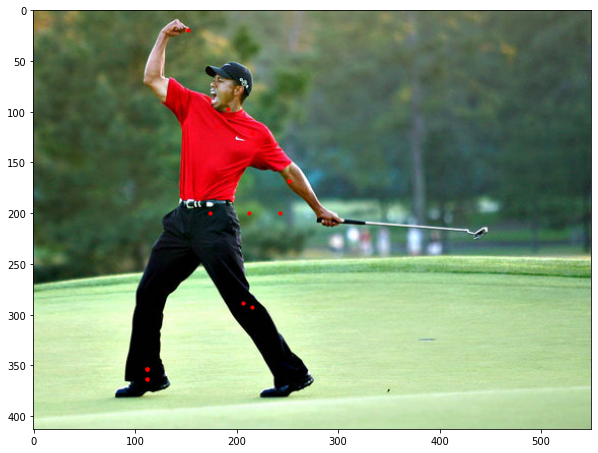

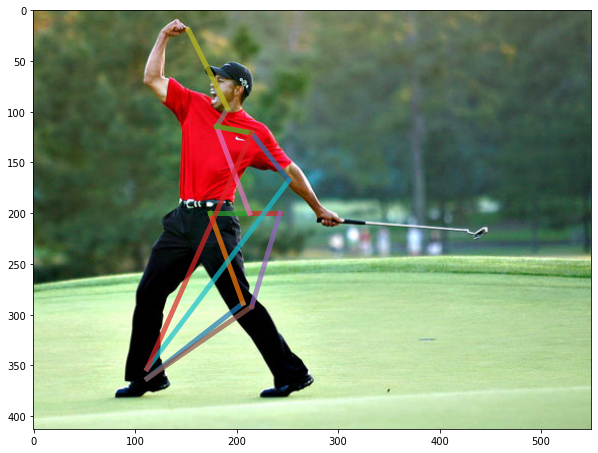

In [49]:
# 결과 이미지
image, keypoints = predict('./test_image.jpg')
draw_keypoints_on_image(image, keypoints)
draw_skeleton_on_image(image, keypoints)